# Using Bayesian Modelling to Predict the Number of COVID19 in Brazil

**Abstract**. One of the main challenges in the predicting the number contaminated for a large country is the discrepancies between each state. Consequently, the number of contaminated people in the data set is uncertain. For this reason, I decided to create a simple model that predicts the number of confirmed cases by state using Bayesian modelling. One of the benefits of this model is to obtain an estimate of the daily growth rate. This work is based on the notebook [2].

# Import

## Modules

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import altair as alt
import dask.dataframe as dd
import sys
from pathlib import Path
from itertools import product
from pprint import pprint
import requests
sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

## Set this to true to see legacy charts
debug=False

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Setup paths

In [2]:
PROJECT_ROOT = Path.cwd().parent
PATH_DATA = PROJECT_ROOT / "data" / "csv"
sys.path.append(str(PROJECT_ROOT))

## Data

The data that I am using is provided by `brasil.io` a Brazilian open data initiative [1].

In [3]:
raw_data = pd.read_csv(str(PATH_DATA / "covid19.csv"))

For my analysis, the relevant columns are:

* Date
* State
* Confirmed: which is the number of confirmed cases on a given day

# Data Auditing

What is contained in the dataset?

## Data Dictionary

In [4]:
data_dict = {x: x for x in list(raw_data.dtypes.index)}

In [5]:
data_dict["confirmed"] = "Number of Confirmed Cases"
data_dict["is_last"] = "Latest Update"
data_dict["confirmed_per_100k_inhabitants"] = "Number of Confirmed Cases per 100k Inhabitants"

In [6]:
list(data_dict.keys())

['city',
 'city_ibge_code',
 'date',
 'estimated_population_2019',
 'is_repeated',
 'is_last',
 'last_available_confirmed',
 'last_available_confirmed_per_100k_inhabitants',
 'last_available_date',
 'last_available_death_rate',
 'last_available_deaths',
 'place_type',
 'state',
 'new_confirmed',
 'new_deaths',
 'confirmed',
 'confirmed_per_100k_inhabitants']

In [7]:
pd.DataFrame(list(data_dict.values()), columns=["Description"], index=list(data_dict.keys()))

Description
city                                                                                     city
city_ibge_code                                                                 city_ibge_code
date                                                                                     date
estimated_population_2019                                           estimated_population_2019
is_repeated                                                                       is_repeated
is_last                                                                         Latest Update
last_available_confirmed                                             last_available_confirmed
last_available_confirmed_per_100k_inhabitants   last_available_confirmed_per_100k_inhabitants
last_available_date                                                       last_available_date
last_available_death_rate                                           last_available_death_rate
last_available_deaths                                                   last_available_deaths
place_type                                                                         place_type
state                                                                                   state
new_confirmed                                                                   new_confirmed
new_deaths                                                                         new_deaths
confirmed                                                           Number of Confirmed Cases
confirmed_per_100k_inhabitants                 Number of Confirmed Cases per 100k Inhabitants

# Data Cleaning

## Parse dates as datetime objects

In [8]:
raw_data["date"] = pd.to_datetime(raw_data["date"])
raw_data.sort_values(by="date", inplace=True)

# Fature Engineering

I am renaming the `last_available_confirmed` to `confirmed`

In [9]:
raw_data.rename(columns={"last_available_confirmed": "confirmed"}, inplace=True)

## Sum Number of Cases per State

In [10]:
group_uf = raw_data.groupby(by=["state", "date"], as_index=False).sum() 

## Cumulative Sum of Number of Cases

In [11]:
for uf, metric in product(group_uf["state"].dropna().drop_duplicates(), ['confirmed']):
    mask = group_uf["state"] == uf
    group_uf.loc[mask, metric] = group_uf.loc[mask, metric].cumsum()

## Counter Number of Days Since 100

In [12]:
for uf in group_uf["state"].dropna().drop_duplicates():
    mask = group_uf["state"] == uf
    temp = group_uf.loc[mask, ["date", "confirmed"]]
    mask100 = temp["confirmed"] >= 100
    date_since_100 = temp.loc[mask100, "date"].min()
    group_uf.loc[mask, "days_since_100"] = (group_uf.loc[mask, "date"] - date_since_100).dt.days

# Plots

To make sure that the data corresponds to what we could expect, I plotted the cumulative number of confirmed infections, below.

Text(0, 0.5, 'Cumulative Number of Cases (Log scale)')

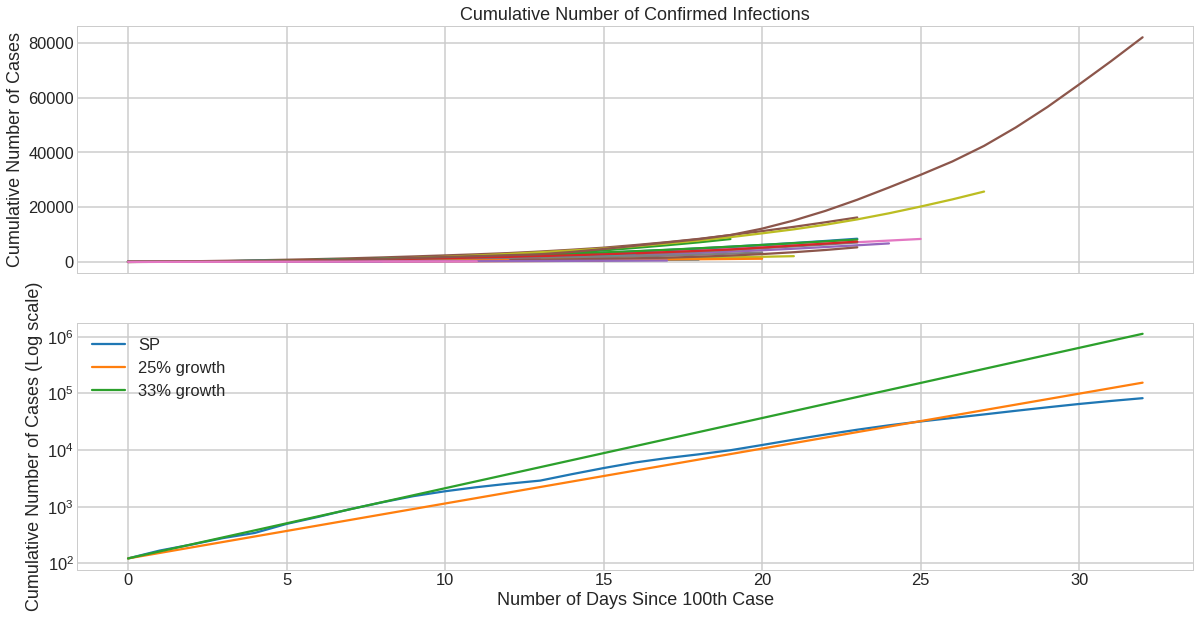

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,10), sharex=True)
for uf in group_uf["state"].drop_duplicates():
    mask = [x and y for (x,y) in zip(group_uf["state"] == uf, group_uf["days_since_100"] >= 0)]
    x = group_uf.loc[mask, "days_since_100"].values
    y25 = group_uf.loc[mask, ["confirmed"]].min()[0]*(1 + 0.25) ** group_uf.loc[mask, "days_since_100"].values
    y33 = group_uf.loc[mask, ["confirmed"]].min()[0]*(1 + 0.33) ** group_uf.loc[mask, "days_since_100"].values
    ax1.plot(x, group_uf.loc[mask, ["confirmed"]], label=uf)
    if uf == "SP":
        ax2.plot(x, group_uf.loc[mask, ["confirmed"]], label=uf)
        ax2.plot(x, y25, label="25% growth")
        ax2.plot(x, y33, label="33% growth")
        ax2.set_yscale("log")
    
plt.legend()
ax1.set_title("Cumulative Number of Confirmed Infections")
ax1.set_ylabel("Cumulative Number of Cases")
ax2.set_xlabel("Number of Days Since 100th Case")
ax2.set_ylabel("Cumulative Number of Cases (Log scale)")

In the figure above, we see that

* In the top graph, the cumulative number of confirmed cases segmented by Brazilian state.
* In the bottom: cumulative number of confirmed case for the state of São Paulo plotted in log scale on the y axis. Also, the daily growth of 25% and 33% are plotted for comparison.

From these graphs, we can state that:

* The cumulative number of confirmed cases has an exponential growth with respect to the time.
* For the state of São Paulo, the data available shows that the daily growth has been between 25% and 33%. Now, it starting to be below 25%

# COVID-19 Growth Rate Prediction

Predictions of COVID-19 Growth Rates Using Bayesian Modeling. Based on the works of Thomas Wiecki and Hamel Husain

The main reason to use Bayesian modelling methodology (MCMC) is due to the presence of uncertainty in the data. This phenomenon occurs due to the large number of the Brazilian population, and limited amount of resources, it is not possible to have a precise number of confirmed cases. 

This model contains the results of a predictive model. The author has tried to make it as accurate as possible. But the COVID-19 situation is changing quickly, and these models inevitably include some level of speculation.

The preliminary analysis of the data show us that the cumulative number of confirmed cases grows exponentially with respect to the time. For this reason I have chosen to model the cumulative number of confirmed cases as an exponential function. The model in considerations is given by
$$ t\mapsto ab^t$$
where $a$ is the is sampled from an initial distribution of confirmed cases, and $b$ is sample from an initial distribution of daily percentage growth.

To take into account the uncertainties of the data, I model the parameters a and d as a distribution and estimate their distributions. To perform this calculation, I used a python library called PyMC3.

For the distribution of the parameters a and d, the mean of the priors were chosen to have normal distributions, and halfnormal distributed standard adeviation, respectively.

After the estimating the parameters, we obtain a posterior distribution: a distribution that better approximates the parameters a and d.

In [14]:
states = group_uf["state"].dropna().drop_duplicates()
n_states = len(states)
df = group_uf.loc[lambda x: (x.days_since_100 >= 0)]

These are the countries included in the model:

In [15]:
#hide_input
',   '.join(sorted(df.state.unique().tolist()))

'AC,   AL,   AM,   AP,   BA,   CE,   DF,   ES,   GO,   MA,   MG,   MS,   MT,   PA,   PB,   PE,   PI,   PR,   RJ,   RN,   RO,   RR,   RS,   SC,   SE,   SP,   TO'

In [16]:
#hide

#####################################
##### This Cell Runs The Model ######
#####################################

with pm.Model() as model:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 100, 50)
    # Group variance
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=n_states)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', 1.33, .5)
    # Group variance
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .5)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=n_states)
    
    # Error
    sigma = pm.HalfNormal('sigma', 500., shape=n_states)
    
    # Create likelihood for each state
    for i, state in enumerate(states):
        df_state = df.loc[lambda x: (x.state == state)]
        
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(state + "x_data", 
                    df_state.days_since_100.values)
        confirmed = pm.Data(state + "y_data", 
                            df_state.confirmed.astype('float64').values)
        
        # We assume a negative binomial likelihood as we are dealing with count data. 
        # A Poisson could also be used but the negative binomial allows us to also model the 
        # variance separately to give more flexibility.
        pm.NegativeBinomial(
            state, 
            (a_ind[i] * b_ind[i] ** x), # Exponential regression
            sigma[i], 
            observed=confirmed)

To take into account the uncertainties of the data, I model the parameters a and d as a distribution and estimate their distributions. To perform this calculation, I used a python library called `PyMC3`.

For the distribution of the parameters `a` and `b`, the mean of the priors were chosen to have normal distributions, and halfnormal distributed standard adeviation, respectively.

After the estimating the parameters, we obtain the posterior distribution: the distribution that better approximates the parameters `a` and `b`.

In [17]:
#hide
with model:
    # Sample posterior
    trace = pm.sample(tune=1500, chains=1, cores=2, target_accept=.9)
    
    # Update data so that we get predictions into the future
    for state in states:
        df_state = df.loc[lambda x: (x.state == state)]
        x_data = np.arange(0, 60)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({state + "x_data": x_data})
        pm.set_data({state + "y_data": y_data})
    
    # Sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=80)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]
Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [02:18<00:00, 14.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 80/80 [00:19<00:00,  4.17it/s]


## Predicted Cases By State

Select a state from the drop down list below to toggle  the visualization. 

In [18]:
#hide

##############################################
#### Pre processing of Data For Altair Viz ###
##############################################

# Flatten predictions & target for each state into a pandas DataFrame
prediction_dfs_list = []

for state in post_pred:
    arr = post_pred[state]
    preds = arr.flatten().tolist() # get predictions in a flattened array
    pred_idx = np.indices(arr.shape)[0].flatten().tolist() # prediction for model (there are many per state, these are the grey lines)
    days_since = np.indices(arr.shape)[1].flatten().tolist() # days since 100 cases
    pred_df = pd.DataFrame({'state': state, 
                            'predictions': preds, 
                            'pred_idx': pred_idx,
                            'days_since_100': days_since}
                          )
    prediction_dfs_list.append(pred_df)

predictionsDF = pd.concat(prediction_dfs_list)


# Compute the maximum value to plot on the y-axis as 15x the last confirmed case
ylims = pd.DataFrame(df.groupby('state').last().confirmed * 15).reset_index()
ylims.columns = ['state', 'ylim']


# Filter out any predictions exceed the y-axis limit
predictionsDF_filtered = (predictionsDF.merge(ylims, on='state', how='left')
                         .loc[lambda x: x.predictions <= x.ylim])


# Compute a 33% daily growth rate (dashed line) as a reference for visualizations
first_case_count = df.groupby('state').first().confirmed.reset_index()
date_anchor = predictionsDF_filtered[['state', 'days_since_100']].drop_duplicates()
max_pred = predictionsDF_filtered.groupby('state').max()[['predictions']].reset_index()
benchmark = (date_anchor
             .merge(first_case_count, on='state', how='left')
             .merge(max_pred, on='state', how='left')
            )
benchmark['benchmark'] = benchmark.apply(lambda x: x.confirmed * (1.3**(x.days_since_100)),
                                         axis=1)
benchmarkDF_filtered = benchmark.loc[lambda x: x.benchmark <= x.predictions]


# Compute the last known total confirmed case, which is the black dot at the end of the red line in the viz
lastpointDF = df.groupby('state').last().reset_index()


# DataFrame of Chart Titles by state.  This a enables a hack to allow Altiar to switch values
titleDF = lastpointDF[['state']]
titleDF['title'] = titleDF.apply(lambda x: x.state + ': Actual vs. Predicted Growth',
                             axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
#hide_input

##################################
#### Construct The Altair Viz ####
##################################

alt.data_transformers.disable_max_rows()

selectState = alt.selection_single(
    name='Select',
    fields=['state'],
    init={'state': 'SP'},
    bind=alt.binding_select(options=sorted(states.tolist()))
)

##### Model Predictions (Grey) #####
width = 275
height= 250

pred = (alt.Chart(predictionsDF_filtered)
        .mark_line(opacity=.15)
        .encode(x=alt.X('days_since_100:Q', axis=alt.Axis(title='Days since 100th confirmed case')),
                y=alt.Y('predictions:Q', 
                        axis=alt.Axis(title='Confirmed cases')),
                color=alt.Color('pred_idx:Q', legend=None, scale=None),)
        .transform_filter(selectState)
       ).properties(
    width=width,
    height=height
)  

predlog = (alt.Chart(predictionsDF_filtered)
        .mark_line(opacity=.15)
        .encode(x=alt.X('days_since_100:Q', axis=alt.Axis(title='Days since 100th confirmed case')),
                y=alt.Y('predictions:Q', 
                        axis=alt.Axis(title=None),
                        scale=alt.Scale(type='log', base=10)),
                color=alt.Color('pred_idx:Q', legend=None, scale=None),)
        .transform_filter(selectState)
        ).properties(
    width=width,
    height=height
)   

##### Mark The Last Case Count #####

# Point

last_point = (alt.Chart(lastpointDF)
              .mark_circle(color="black", size=40)
              .encode(x='days_since_100:Q',
                      y='confirmed:Q')
              .transform_filter(selectState)
             )

# Label
last_point_label = (alt.Chart(lastpointDF)
                    .mark_text(align='right', dx=-10, dy=-15, fontSize=15)
                    .encode(x='days_since_100:Q',
                            y='confirmed:Q',
                            text='confirmed')
                    .transform_filter(selectState)
                   )

##### Place 133% Dotted Line Reference On Graph #####
guide = (alt.Chart(benchmarkDF_filtered)
        .mark_line(color='black', opacity=.5, strokeDash=[3,3])
        .encode(x='days_since_100:Q',
                y='benchmark:Q',
                )
        .transform_filter(selectState)
        )


##### Dynamic Chart Title


title_main = alt.Chart(titleDF).mark_text(dy=-15, dx=325, size=20).encode(
    text='title:N'
    ).transform_filter(selectState)


title_linear = (alt.Chart(alt.Data(values=[{'title': 'Y axis is on a linear scale'}]))
                .mark_text(dy=-150, size=15)
                .encode(text='title:N')
               )
title_log = (alt.Chart(alt.Data(values=[{'title': 'Y axis is on a log scale'}]))
                .mark_text(dy=-150, size=15)
                .encode(text='title:N')
               )

###### Legend (Hacked)
source = pd.DataFrame.from_records([{"img": "https://covid19dashboards.com/images/covid-bayes-growth-legend.png"}])
legend = (alt.Chart(source)
          .mark_image(dy=-150,
                      width=200,
                      height=150)
          .encode(url='img')
         )

##### Actual Cases (Red) #####
actual = (alt.Chart(df).mark_line(color="red")
          .encode(x='days_since_100:Q',
                  y='confirmed:Q')
          .transform_filter(selectState)
         )

annotations = last_point + last_point_label + guide + actual
linear_chart = pred.add_selection(selectState) + annotations + title_linear
log_chart = predlog + annotations + title_log + title_log

##### Layer All Charts Together And Configure Formatting #####
(
((title_main + legend) & ( linear_chart | log_chart ))
.configure_title(fontSize=20)
.configure_axis(labelFontSize=15,titleFontSize=18, grid=False)
)

alt.VConcatChart(...)

## Plot Growth Rate Predictions

I plot the estimation of the daily growth (parameter `b`) for seven states, below:

Text(0.5, 0.98, 'Posterior of daily growth')

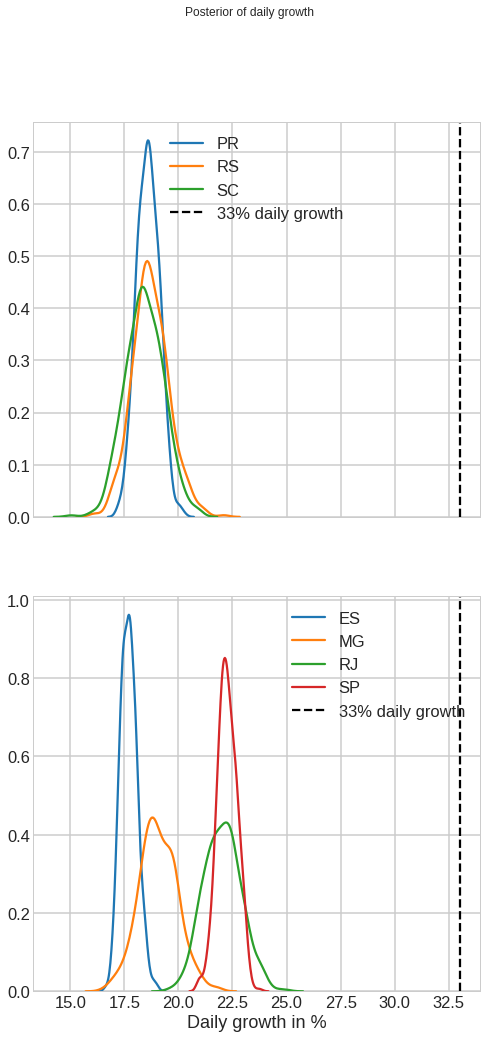

In [24]:
#hide_input

south = ["PR", "SC", "RS"]
southeast = ["SP", "RJ", "MG", "ES"]

state_groups = [south, southeast]
line_styles = ['-', ':', '--', '-.']


fig, axs = plt.subplots(nrows=len(state_groups), figsize=(8, 16), sharex=True)

for ax, state_group in zip(axs, state_groups):
    for i, state in enumerate(states):
        if state in state_group:
            sns.distplot((trace['b_ind'][:, i] * 100) - 100, ax=ax, label=state, hist=False)
        
    ax.axvline(33, ls='--', color='k', label='33% daily growth')
    ax.legend()
ax.set_xlabel('Daily growth in %')
plt.suptitle('Posterior of daily growth')

## Model Diagnostics - Trace Plots

The following trace plots help to assess the convergence of the MCMC sampler.  You can safely ignore this if not familiar with [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

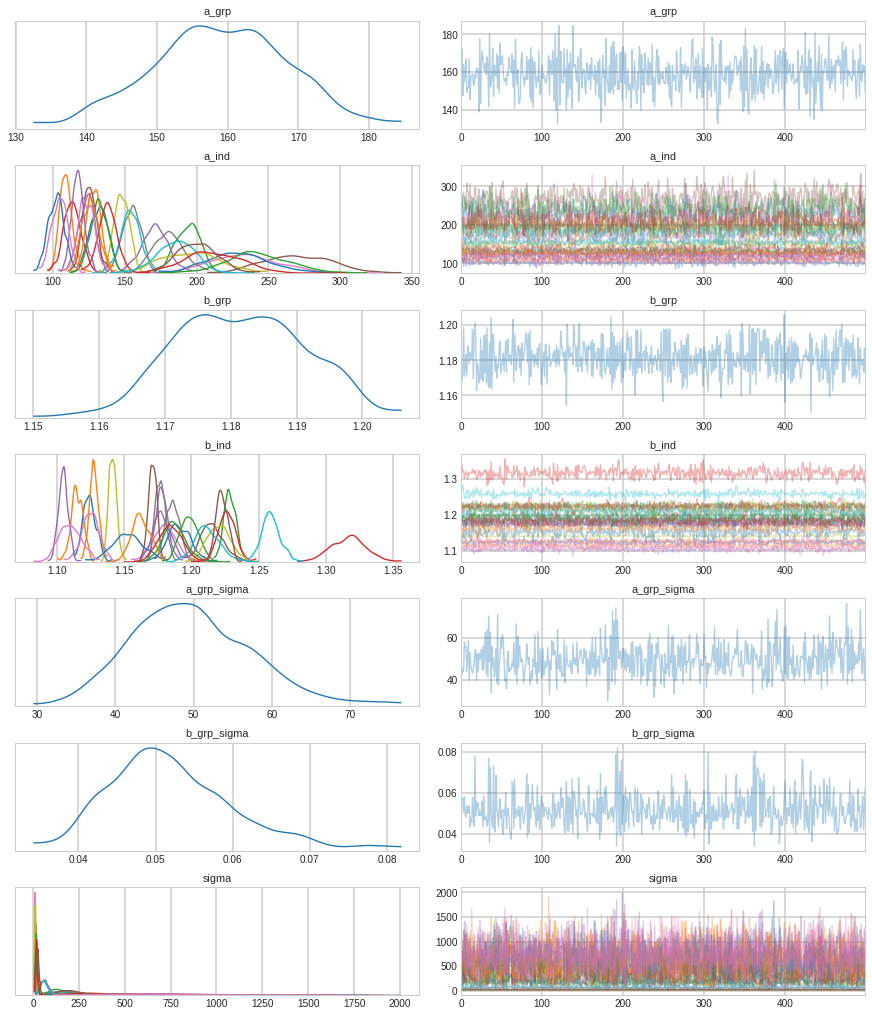

In [25]:
#hide_input
az.plot_trace(trace, compact=True);

# Points to Keep in Mind

1. The predictions and estimations may not represent the reality, as the number of cases are often under represented due to limited resources or patients lacking symptoms.

2. This model does not take into account the influence of mitigation strategies over time, and / or the number of recovered people.

# References

* [1] Brasil.io, https://www.brasil.io/home, accessed on 6th April 2020.
* [2] Thomas Wiecki and Hamel Husain, "COVID-19 Growth Rate Prediction", accessed on 13th of April 2020.